In [517]:
import pandas as pd

#import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
#to remove outliers
from scipy import stats
import datetime as dt
import geopy.distance
from sklearn.model_selection import train_test_split 
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline



## My Approach to the problem

As you will see in this notebook, most of the work is on data exploration. I tried to understand the data, transform it, try to see patterns in the data before modelling phase.

The steps I have taken is as follows:

### Remove the Outliers
First I remove the outliers in the model. Specifically outliers for the end coordinates. Why certain outliers are removed is discussed under those sections

### Date Time Feature Engineering
The data time information will be engineered so that we will have categorical information about week, day of the week, hour of the pick up, moment of the pick up. But most importantly day will be divided into half hour bins and each ride will be marked on which bin it falls into

A lot of data exploration is done in this part of the work. It is found that there is a trend in the number of rides per week. It is increasing

### Distance and Fare per Distance Calculation

Ride distance is calculated first. Then fare per distance is checked. There is not much variation in fare per distance data. Less variation means it is not a good candidate for using in a model. I was expecting to see some variation here.

### Clustering the pick up and drop Locations

I have created zones using the coordinate information for pick up and drop locations. My motivation is that you can do better data exploration using clusters and the model can be more useful for the end user this way. Later some data exploration was conducted to get more information about clusters(fare per cluster, pick up numbers per location..etc)

### Modeling

If we are trying to estimate number of pick ups at a certain neighborhood at a certain hour interval, using a model here does not make much sense in my approach since each time interval occurs only once in the data for pick ups. Total pick ups is an aggregation data here. But if the data's time span is larger and there are other information, a model can be created for number of pick ups. Still I created the dataframes for the number of pick up demands for each time interval, each day, each week and for each locality(cluster). One thing that I could to is to create a time series model to find out the trend and estimate the following weeks' pick up numbers, unfortunately I didn't have time to do this. I wanted to be done in the given time frame. But one probably needs more data for this still. This is only 4 weeks of data, it is 4 data points if one uses weekly data.

I also estimated cab fare using the time info and locality. LightGBM is used for this purpose. For the location info first the cluster info is used. Then in second model exact coordinates are used. This way a cab driver can have a rough information on what fare he would get a certain location and certain time of the week. 

### How I would design and deploy such a model and how to communicate the information

Estimating excess demand is tricky. I would still divide the city in neighborhoods and estimate the number of pick ups for each location using a model that spans longer time. I would deploy a time series model to see trends. But I would use information like weather, local events. Special locations such as airports can be treated specifically

This data would be checked against supply information and drivers can be diverted to places where excess demand is estimated. 

For drivers a fare and travel distance estimation information can be provided as well.

As for deployment, I can't go into details of such an endavor but the drivers should be able to enter time and location to an app to see if there is extra demand and fare predictions. 

# How to use and validate the model estimations

Proof is in the pudding for demand estimation. One can just estimate the number of pick ups and then see how the demand moves. The customers who are not in a hurry can be offered a different pick up time with discounts when there is demand surge estimated in certain location.

But for fare estimation, things are a little more complicated. Many drivers moving to a location estimating high fares will drop their revenues. So model's success will cause its failure in terms of results. In that case in order to check model's success, certain locations may be used as control location sometimes and some historical average can be provided. But ethical aspect of this can be discussed as certain drivers will be left with 'inferior' estimation


In [597]:
#import dataframe
df = pd.read_csv('./Data/robotex5.csv')
df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100


In [598]:
#some descriptions of data frame and its columns
df_orig = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627210 entries, 0 to 627209
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   start_time  627210 non-null  object 
 1   start_lat   627210 non-null  float64
 2   start_lng   627210 non-null  float64
 3   end_lat     627210 non-null  float64
 4   end_lng     627210 non-null  float64
 5   ride_value  627210 non-null  float64
dtypes: float64(5), object(1)
memory usage: 28.7+ MB


In [599]:
#some more descriptions
df.describe()

,start_lat,start_lng,end_lat,end_lng,ride_value
count,627210.000000,627210.000000,627210.000000,627210.000000,627210.000000
mean,59.428682,24.743468,59.397797,24.724847,2.261384
std,0.021764,0.056872,1.392755,1.650709,44.889892
min,59.321557,24.505199,-37.819979,-122.453962,0.107628
25%,59.418803,24.713140,59.415215,24.707919,0.545250
50%,59.432069,24.744674,59.430697,24.744335,1.059000
75%,59.439024,24.768115,59.439262,24.773924,1.712000
max,59.566998,24.973743,61.552744,144.966110,3172.701000


In [600]:
#store column names
df_columns = df.columns
df_columns

Index(['start_time', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'ride_value'],
      dtype='object')

In [601]:
#just checking for null values once more
for column in df.columns:
    print(column, "has", df[column].isnull().sum(), "null values")

start_time has 0 null values
start_lat has 0 null values
start_lng has 0 null values
end_lat has 0 null values
end_lng has 0 null values
ride_value has 0 null values


In [602]:
df.nunique()

start_time    622643
start_lat     352311
start_lng     352311
end_lat       320715
end_lng       320715
ride_value    114603
dtype: int64

### Visualize the coordinates to see the outliers

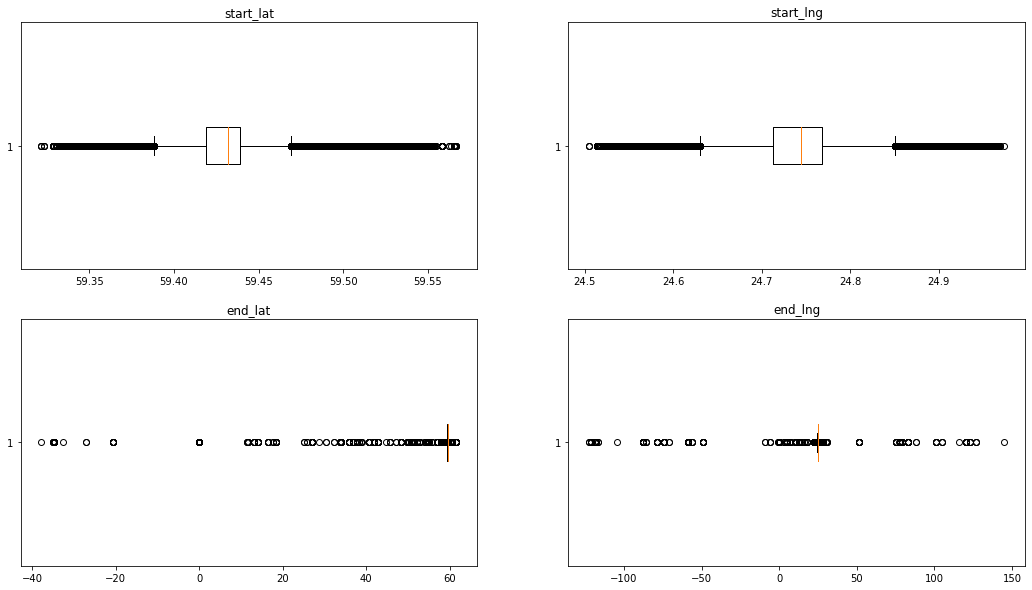

In [91]:
#checking boxplot graphs
#drop coordinates have some extreme outliers compared to pick up ones

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

ax[0,0].boxplot(df[df_columns[1]], vert=False)
ax[0,0].set_title(df_columns[1])
#ax[0,0].set_ylabel(df_columns[1])
ax[0,1].boxplot(df[df_columns[2]], vert=False)
ax[0,1].set_title(df_columns[2])
#ax[0,1].set_ylabel(df_columns[2])
ax[1,0].boxplot(df[df_columns[3]], vert=False)
ax[1,0].set_title(df_columns[3])
#ax[1,0].set_ylabel(df_columns[3])
ax[1,1].boxplot(df[df_columns[4]], vert=False)
ax[1,1].set_title(df_columns[4])
#ax[1,1].set_ylabel(df.columns[4])

plt.show()

The end coordinates have some outliers. These outliers contain information. They may be left behind, on the other hand in my approach I would like to present the drivers some expected fare and these outliers affect the expected values a lot. These kinds of rides are far and in between and they may be thought more as lottery (if the data is correct)

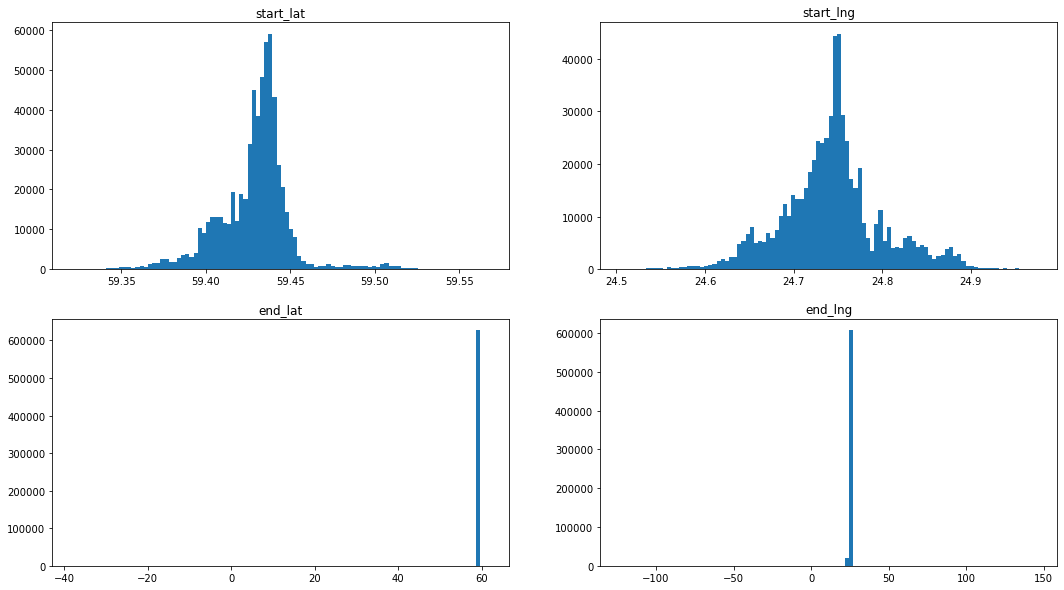

In [94]:
#histograms without eliminating outliers on the end point
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

ax[0,0].hist(df[df_columns[1]], bins=100)
ax[0,0].set_title(df_columns[1])
#ax[0,0].set_ylabel(df_columns[1])
ax[0,1].hist(df[df_columns[2]], bins=100)
ax[0,1].set_title(df_columns[2])
#ax[0,1].set_ylabel(df_columns[2])
ax[1,0].hist(df[df_columns[3]], bins=100)
ax[1,0].set_title(df_columns[3])
#ax[1,0].set_ylabel(df_columns[3])
ax[1,1].hist(df[df_columns[4]], bins=100)
ax[1,1].set_title(df_columns[4])
#ax[1,1].set_ylabel(df_columns[4])

plt.show()

Removing extreme values. The problem is especially acute for drop points.

Z scores and the top percentile values will be calculated. Top 0.02% of the deviations from the mean will be marked and removed.

In [603]:
#create new columns including z scores. they will be dropped after dropping the excess scores.
for i in range(4):
    z_colname = df_columns[i+1] + '_z_score'
    df[z_colname] = np.abs(stats.zscore(df[df_columns[i+1]]))
#create deviations from mean. percentile will be calculated using this. they will be dropped after dropping the excess scores.
for i in range(4):
    dev_colname = df_columns[i+1] + '_mean_deviation'
    perc_colname = df_columns[i+1] + '_percentile'
    meanvalue = df[df_columns[i+1]].mean()
    df[dev_colname] = np.abs(df[df_columns[i+1]] - meanvalue)
    df[perc_colname] = np.percentile(df[df_columns[i+1]+'_mean_deviation'], 99.8)

In [604]:
df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,start_lat_z_score,start_lng_z_score,end_lat_z_score,end_lng_z_score,start_lat_mean_deviation,start_lat_percentile,start_lng_mean_deviation,start_lng_percentile,end_lat_mean_deviation,end_lat_percentile,end_lng_mean_deviation,end_lng_percentile
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825,0.954463,0.943025,0.082736,0.064689,0.020773,0.091682,0.053631,0.198935,0.115230,0.151875,0.106783,0.353374
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750,0.595866,0.338390,0.020573,0.035275,0.012968,0.091682,0.019245,0.198935,0.028653,0.151875,0.058229,0.353374
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025,0.308857,0.111260,0.024487,0.022258,0.006722,0.091682,0.006328,0.198935,0.034104,0.151875,0.036741,0.353374
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600,0.999949,1.485130,0.011993,0.050400,0.021762,0.091682,0.084462,0.198935,0.016704,0.151875,0.083195,0.353374
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100,0.287563,0.178883,0.065630,0.091672,0.006258,0.091682,0.010173,0.198935,0.091406,0.151875,0.151324,0.353374


Removing the deviations in top 0.02% for the end lattitudes. But for start lattitudes, only 4 std deviation of outliers are removed.

In [605]:
#for i in range(1,3):
#    df = df[df[df_columns[i]+'_z_score'] < 4.]
for i in range(3,5):
    df = df[df[df_columns[i]+'_mean_deviation'] < df[df_columns[i]+'_percentile']]

Histograms after removing outliers

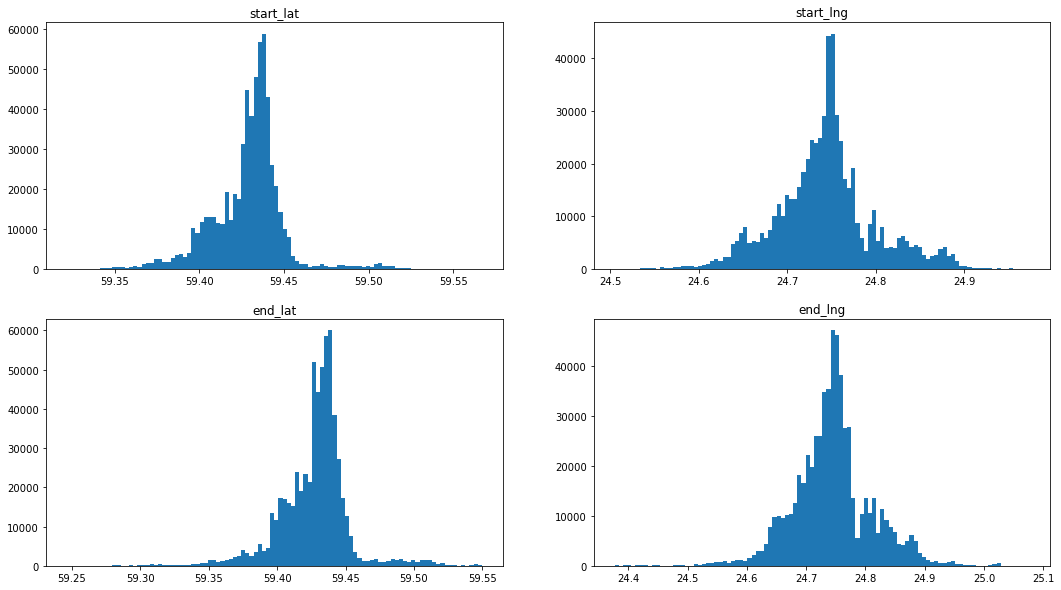

In [606]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

ax[0,0].hist(df[df.columns[1]], bins=100)
ax[0,0].set_title(df.columns[1])
#ax[0,0].set_ylabel(df.columns[1])
ax[0,1].hist(df[df.columns[2]], bins=100)
ax[0,1].set_title(df.columns[2])
#ax[0,1].set_ylabel(df.columns[2])
ax[1,0].hist(df[df.columns[3]], bins=100)
ax[1,0].set_title(df.columns[3])
#ax[1,0].set_ylabel(df.columns[3])
ax[1,1].hist(df[df.columns[4]], bins=100)
ax[1,1].set_title(df.columns[4])
#ax[1,1].set_ylabel(df.columns[4])

plt.show()

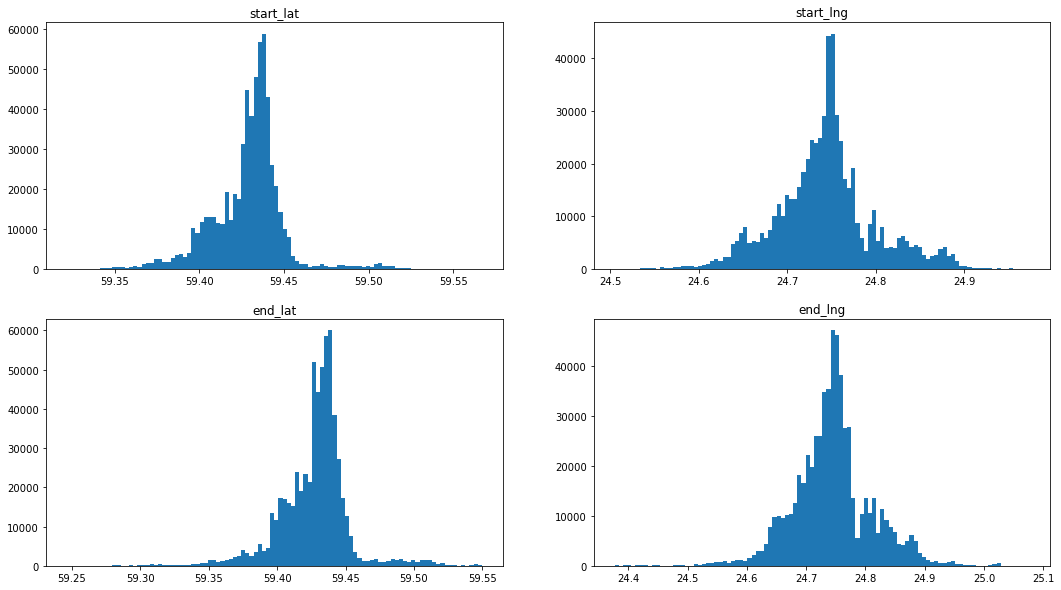

In [70]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

ax[0,0].hist(df[df.columns[1]], bins=100)
ax[0,0].set_title(df.columns[1])
#ax[0,0].set_ylabel(df.columns[1])
ax[0,1].hist(df[df.columns[2]], bins=100)
ax[0,1].set_title(df.columns[2])
#ax[0,1].set_ylabel(df.columns[2])
ax[1,0].hist(df[df.columns[3]], bins=100)
ax[1,0].set_title(df.columns[3])
#ax[1,0].set_ylabel(df.columns[3])
ax[1,1].hist(df[df.columns[4]], bins=100)
ax[1,1].set_title(df.columns[4])
#ax[1,1].set_ylabel(df.columns[4])

plt.show()

In [607]:
df.shape

(625336, 18)

Checking the fare histogram to see if there are outliers after removing the outliers in the coordinate side. It seems like there are no outliers there

(array([1.9935e+04, 8.8990e+03, 1.0249e+04, 1.1136e+04, 1.2423e+04,
        1.2420e+04, 1.2473e+04, 1.2842e+04, 1.3066e+04, 1.3092e+04,
        1.2125e+04, 1.1980e+04, 1.1994e+04, 1.1581e+04, 1.1334e+04,
        1.1505e+04, 1.1461e+04, 1.1244e+04, 1.0608e+04, 1.0601e+04,
        1.1175e+04, 1.0703e+04, 1.0327e+04, 1.0019e+04, 9.8230e+03,
        9.3550e+03, 9.7170e+03, 9.6500e+03, 9.7760e+03, 9.6480e+03,
        9.4280e+03, 9.3710e+03, 9.2670e+03, 9.2050e+03, 9.1070e+03,
        8.7490e+03, 8.4550e+03, 8.0710e+03, 8.0390e+03, 8.0500e+03,
        7.6600e+03, 7.2970e+03, 7.4790e+03, 7.0480e+03, 6.6990e+03,
        6.5650e+03, 6.3120e+03, 6.1690e+03, 5.7720e+03, 5.5700e+03,
        5.4130e+03, 5.2020e+03, 4.9220e+03, 4.8140e+03, 4.5410e+03,
        4.2060e+03, 3.9430e+03, 4.0940e+03, 3.8090e+03, 3.5780e+03,
        3.5160e+03, 3.5270e+03, 3.2890e+03, 3.1930e+03, 3.0360e+03,
        2.9200e+03, 2.8360e+03, 2.6960e+03, 2.5890e+03, 2.4820e+03,
        2.4670e+03, 2.2310e+03, 2.1810e+03, 2.03

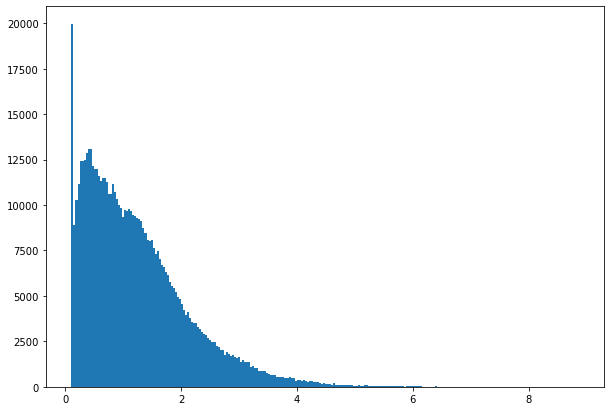

In [100]:
fig = plt.figure(figsize =(10, 7))

plt.hist(df['ride_value'], bins=250)

### Visiualizing the pickup and drop locations on a scatter plot

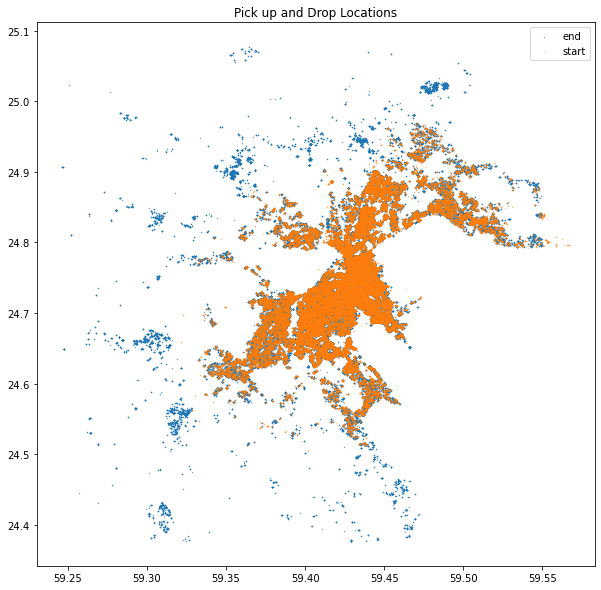

In [570]:
fig = plt.figure(figsize =(10, 10))
plt.scatter(df['end_lat'], df['end_lng'], s=0.1, label='end')
plt.scatter(df['start_lat'], df['start_lng'], s=0.1, label='start', alpha=0.5)
plt.title('Pick up and Drop Locations')
plt.legend()

## DATE TIME FEATURE ENGINEERING

First we will convert the date time info to a date-time object

In [608]:
#Drop the unnecessary columns created during the outlier detection
df = df[df_columns].copy()
#convert string to datetime object
df['start_time'] = pd.to_datetime(df['start_time'])
df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100


We will convert the minute info to half of an hour. it should be more useful later for binning the data

In [609]:
#convert minutes to half hour information. We will mark if the minute info is in the first or second half of the hour
def converhalf(min):
    if min<30:
        return 0
    # if 15 <= min < 30:
    #     return 1
    # if 30 <= min < 45:
    #     return 2
    else:
        return 1


Extract all the time information we can from the start time.

In [610]:
df.loc[:, 'start_minute'] = df['start_time'].dt.minute
df["start_half"] = df['start_minute'].apply(lambda minute: converhalf(minute))
df.loc[:, 'start_hour'] = df['start_time'].dt.hour
df.loc[:, 'start_weekday'] = df['start_time'].dt.day_name()
df.loc[:, 'start_day_month'] = df['start_time'].dt.day
df.loc[:, 'start_month'] = df['start_time'].dt.month
df.loc[:, 'start_day'] = df['start_time'].dt.dayofweek
df['start_week'] = (df['start_day_month']-1) // 7 #find the week 
df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,start_minute,start_half,start_hour,start_weekday,start_day_month,start_month,start_day,start_week
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825,2,0,15,Sunday,6,3,6,0
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750,15,0,11,Thursday,10,3,3,1
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025,23,0,14,Sunday,6,3,6,0
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600,11,0,9,Thursday,3,3,3,0
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100,13,0,0,Sunday,6,3,6,0


Finally I will create bins of the day. Every half hour will be a bin. 2:15 am will be in the 5th bin of the day.
Then create a bin information for the whole week
Then create a bin information for the whole month

In [611]:
df["start_bin_day"] = 2*df["start_hour"] + df["start_half"]
df["start_bin_week"] = 48*df["start_day"] + df["start_bin_day"]
df["start_bin_month"] = 48*df["start_day_month"] + df["start_bin_day"]
df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,start_minute,start_half,start_hour,start_weekday,start_day_month,start_month,start_day,start_week,start_bin_day,start_bin_week,start_bin_month
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825,2,0,15,Sunday,6,3,6,0,30,318,318
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750,15,0,11,Thursday,10,3,3,1,22,166,502
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025,23,0,14,Sunday,6,3,6,0,28,316,316
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600,11,0,9,Thursday,3,3,3,0,18,162,162
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100,13,0,0,Sunday,6,3,6,0,0,288,288


## Some data exploration using time information

Check the number of rides for the quarterly bins for every bin of the day across the week. Each week is aggregated

<AxesSubplot:title={'center':'Rides for the quarterly bins for every day across the week'}, xlabel='start_bin_day'>

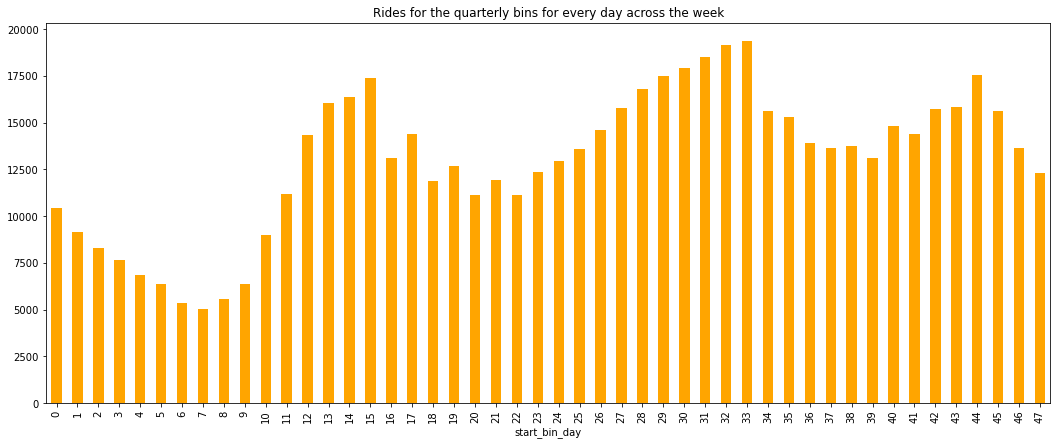

In [612]:
df.pivot_table(values='start_time', index=['start_bin_day'], aggfunc='count')\
            .plot(kind='bar', figsize=(18,7), color='orange', legend=False, title='Rides for the quarterly bins for every day across the week')

Similar as above. But the x-axis include all the quarter of hours of the week. Colors are different days. For some reason bar graph don't play well at that level, hence the scatter

Text(0.5, 1.0, 'Number of rides per quarter hour of the day across the week (each color is a different day of the week)')

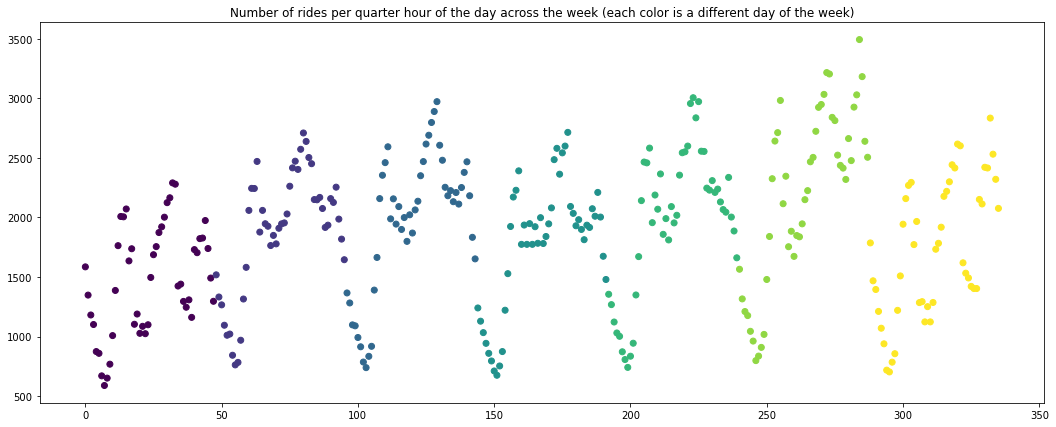

In [452]:
table = df.pivot_table(values='start_time', index=['start_day','start_bin_week'], aggfunc='count')
table.reset_index(inplace=True)

fig = plt.figure(figsize =(18, 7))
plt.scatter(table['start_bin_week'], table['start_time'], c = table['start_day'])
plt.title('Number of rides per quarter hour of the day across the week (each color is a different day of the week)')

Finally number of rides per week of the day. 

<AxesSubplot:title={'center':'Number of rides per day of the week'}, xlabel='start_day'>

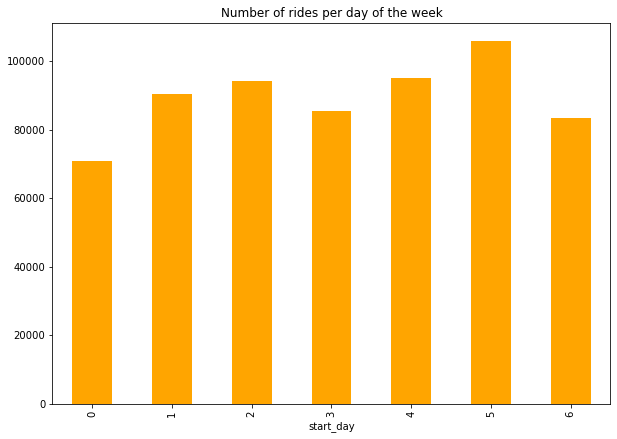

In [453]:
df.pivot_table(values='start_time', index=['start_day'], aggfunc='count').plot(kind='bar', figsize=(10,7), 
                color='orange', legend=False, title='Number of rides per day of the week')

<AxesSubplot:title={'center':'Number of rides per day across the month'}, xlabel='start_day_month'>

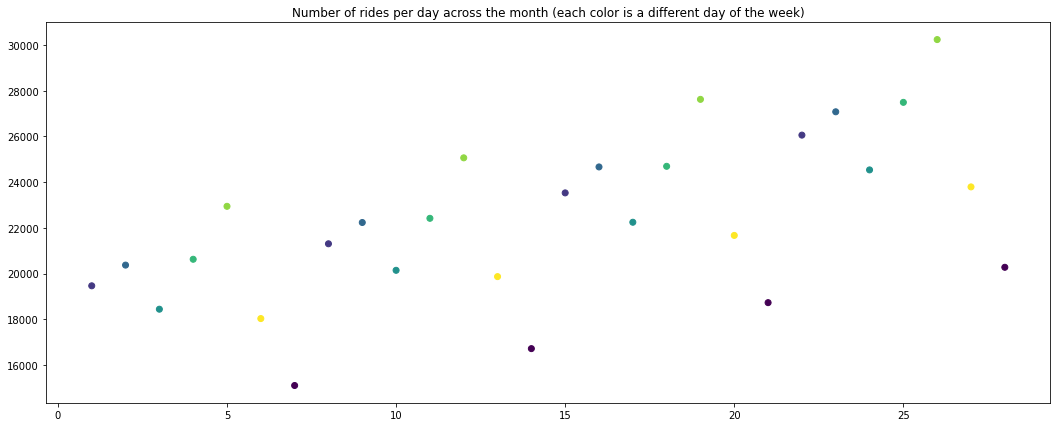

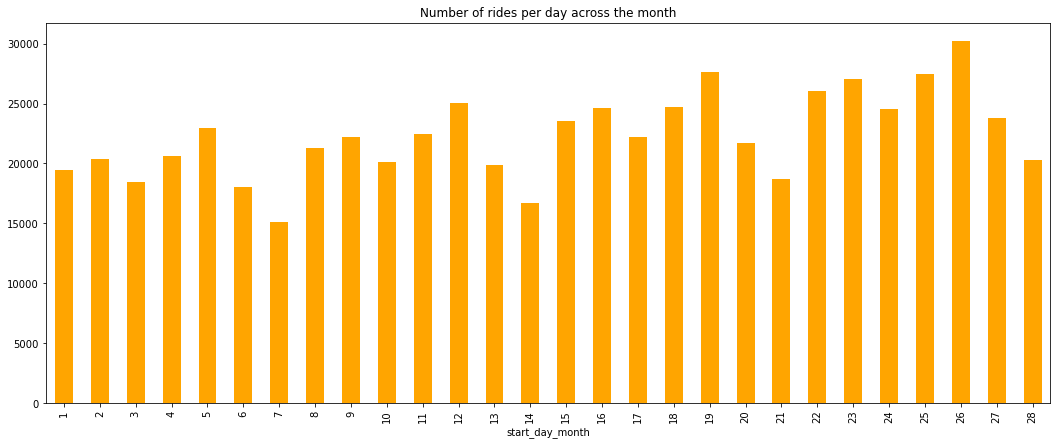

In [454]:
table = df.pivot_table(values='start_time', index=['start_day_month','start_day'], aggfunc='count')
table.reset_index(inplace=True)

fig = plt.figure(figsize =(18, 7))
plt.scatter(table['start_day_month'], table['start_time'], c = table['start_day'])
plt.title('Number of rides per day across the month (each color is a different day of the week)')


df.pivot_table(values='start_time', index=['start_day_month'], aggfunc='count').plot(kind='bar', 
            figsize=(18,7), color='orange', legend=False, title='Number of rides per day across the month')

One thing that is kind of visible at the top graph is the existence of trend. Each sunday we get more and more rides according to this graph. But we can make it more visible by graphing each day separately (1st day of week, 2nd day of week). following tables do that. First graph includes all mondays, second include all Tuesdays...etc

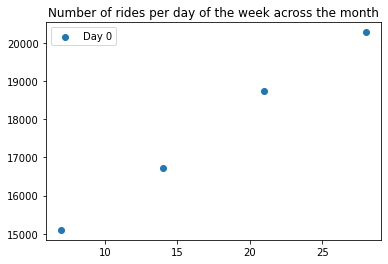

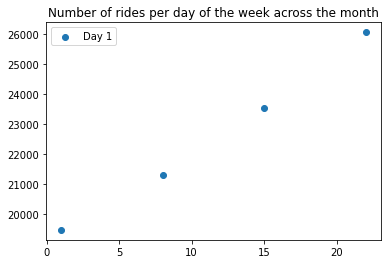

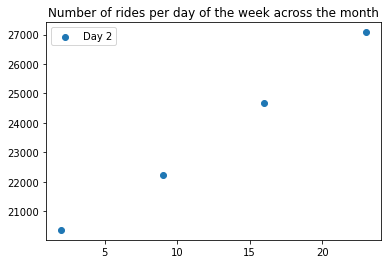

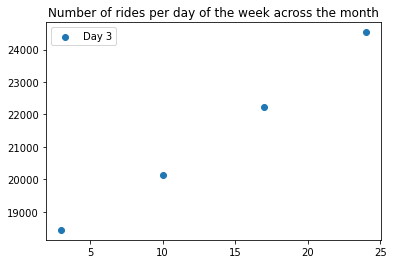

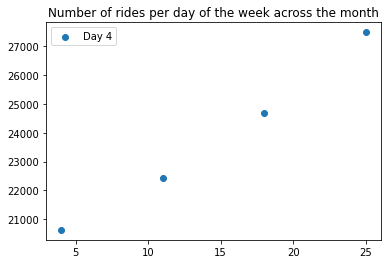

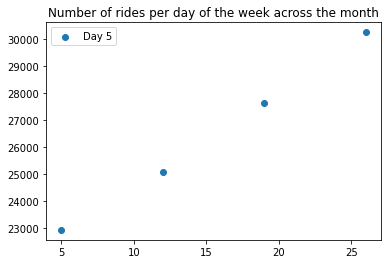

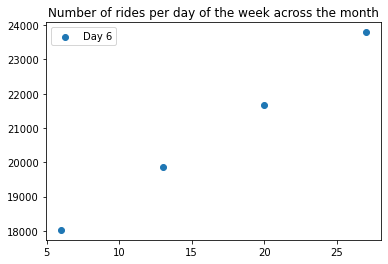

In [455]:
table = df.pivot_table(values='start_time', index=['start_day_month','start_day'], aggfunc='count')
table.reset_index(inplace=True)

for i in range(7):
    tableday = table[table['start_day']==i]
    fig = plt.figure()
    plt.scatter(tableday['start_day_month'], tableday['start_time'], label='Day ' + str(i))
    plt.legend()
    plt.title('Number of rides per day of the week across the month')


So weeks are not same as each other. we see growth here. This means which week of the month you are in should be a variable if you estimate number of rides demanded. If this trend extends to other months, the trend should be handled properly (it can be removed and then added as a baseline to number of rides taken estimation)

One last thing to check average fare information per day. We would like to see if there is a trend there

Text(0.5, 1.0, 'Mean fare per day of the month')

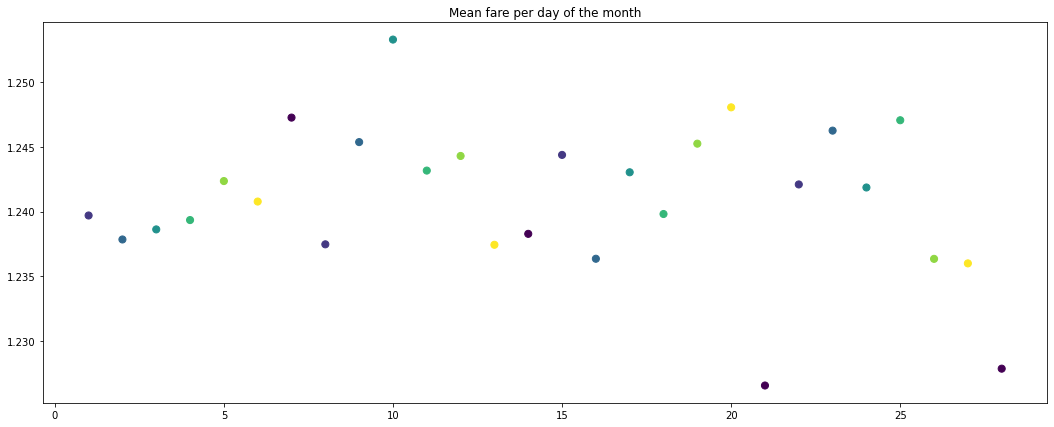

In [456]:
table = df.pivot_table(values='ride_value', index=['start_day_month','start_day'], aggfunc='mean')
table.reset_index(inplace=True)

fig = plt.figure(figsize =(18, 7))
plt.scatter(table['start_day_month'], table['ride_value'], c = table['start_day'], s=50)
plt.title('Mean fare per day of the month')



here we see some variation in average fare value depending on day of the month and day of the week, but it is not trend and the variation does not seem to be too big.

<AxesSubplot:title={'center':'Average fare for the quarterly hour bins for every day across the week'}, xlabel='start_bin_day'>

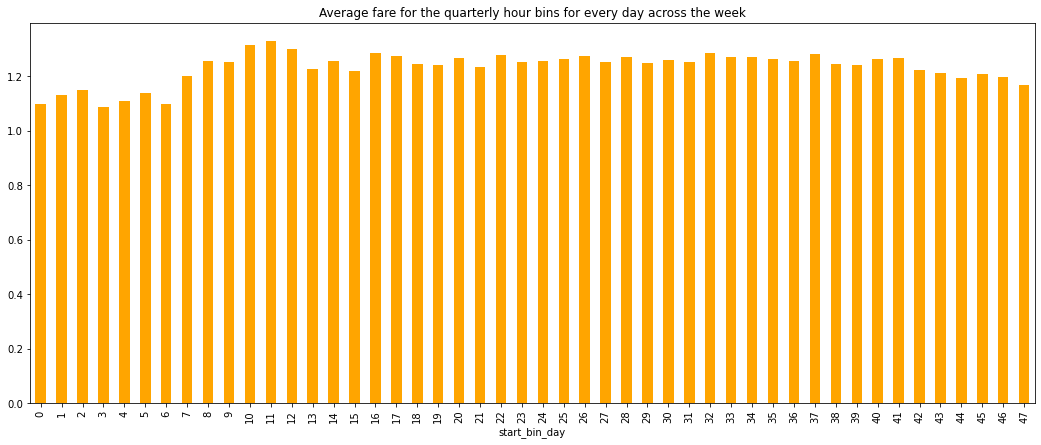

In [457]:
df.pivot_table(values='ride_value', index=['start_bin_day'], aggfunc='mean')\
            .plot(kind='bar', figsize=(18,7), color='orange', legend=False, title='Average fare for the quarterly hour bins for every day across the week')


## CALCULATE RIDE DISTANCE

We'll use a library to calculate ride distance. We want to see if there is any useful information here

In [613]:
#calculate distance using 4 coordinates we have
def calculate_distance(start_lat, start_lng, end_lat, end_lng):
    coord1 = (start_lat, start_lng)
    coord2 = (end_lat, end_lng)
    return geopy.distance.distance(coord1, coord2).km

In [614]:
df["travel_distance"] = df.apply(lambda x: calculate_distance(x.start_lat, x.start_lng, x.end_lat, x.end_lng), axis=1)


### CALCULATE FARE PER RIDE DISTANCE 

The fare per km can be an indicator for high demand if surge price is applied to demand

In [616]:
df["fare_per_distance"] = df["travel_distance"]/df["ride_value"]

Text(0.5, 1.0, 'fare_per_distance')

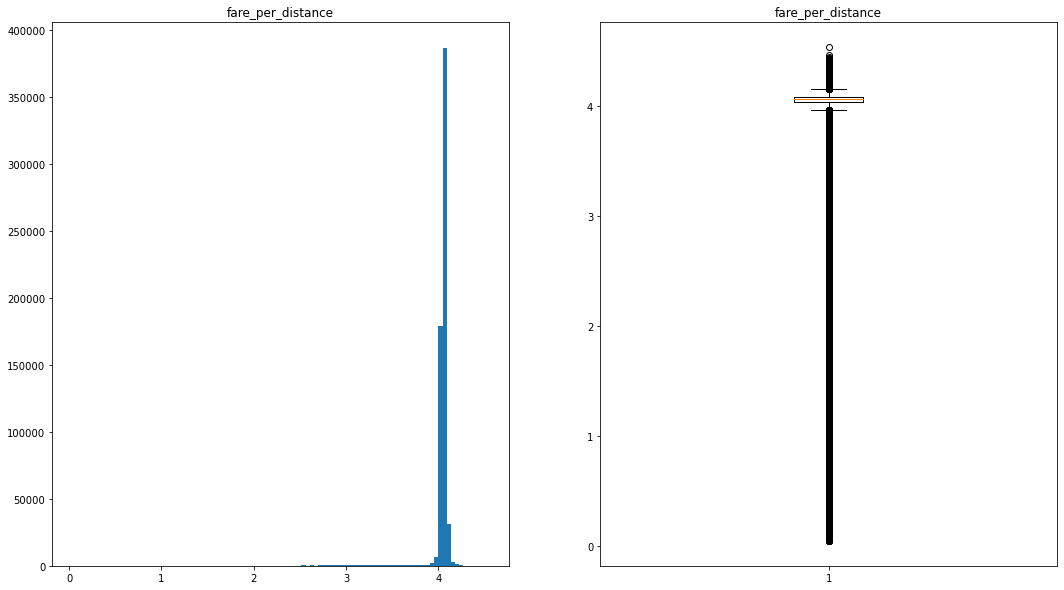

In [162]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))

ax[0].hist(df["fare_per_distance"], bins=100)
ax[0].set_title("fare_per_distance")
ax[1].boxplot(df["fare_per_distance"])
ax[1].set_title("fare_per_distance")

In [168]:
print("mean of the fare per km is", df["fare_per_distance"].mean())
print("99th percentile for fare per km is", np.percentile(df["fare_per_distance"], 99))
print("3rd percentile for fare per km is", np.percentile(df["fare_per_distance"], 3))

mean of the fare per km is 4.023078675172787
99th percentile for fare per km is 4.127723133591521
3rd percentile for fare per km is 3.967193114274294


We don't see much of variation here. I highly doubt estimating fare per km would be a fruitful endavour

In [617]:
#in case I need to restart the process, don't want to spend time on cleannig data
df.to_csv('df_distance_datetime_outlier.csv')

## CLUSTERING THE LOCATION

WHY CLUSTERING:

A driver will want to know what is the average fare, distance, number of rides is demanded around a neighborhood. Neighborhood info is more useful compared to Lattitude and Longtitude information. It will also smooth out irregularities in the data.

We will conduct some location clustering. FOr this purpose we will import standardizing library, clustering library and the libraries for finding optimal number of clustering.

k-means clustering is used since we are more or less literally clustering for euclidean distances here (there is the issue of world being globe and lattitude differences are being twice long as longtitude but I will ignore this issue. This can be compensated for with appropriate coefficient)

In [618]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
#Next two are used to find optimum number of clusters
from kneed import KneeLocator

First scale the data for start conditions

In [619]:
scaler = StandardScaler()

scaler.fit(df[df_columns[1:3]])
scaledfeatures = scaler.transform(df[df_columns[1:3]])
scaledfeatures.shape

(625336, 2)

In [620]:
scaler.mean_

array([59.42868277, 24.74347239])

CLUSTERING

First we will run different number of clustering numbers to find the "optimal one". We will try to check SSE to find the 'elbow location'

In [216]:
kmeans_params = {"init": "random",
        "n_init": 10, "max_iter": 300, "random_state": 42,}
   
# A list holds the SSE values for each k
sse = []
for k in range(3, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_params)
    kmeans.fit(scaledfeatures)
    sse.append(kmeans.inertia_)

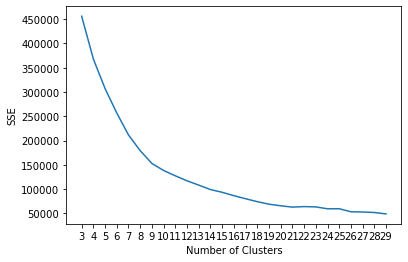

In [218]:
plt.plot(range(3, 30), sse)
plt.xticks(range(3, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Number of clusters is a more complicated business than it looks. One can check silhoutte score to find the optimal number but it takes a long time on this data set. Besides since this is a city, expert opinion can be used as well. There is a package that determines the elbow location on the graph above (kneed), but by no means this means it is the optimal number of clusters.

In [220]:
kl = KneeLocator(range(3, 30), sse, curve="convex", direction="decreasing")
kl.elbow

9

We will use 9 clusters but more can be used depending on the expert opinion and other metrics. 

Each cluster will have similar number of rides. 

In [621]:
kmeans = KMeans(
        init="random",
        n_clusters=9,
        n_init=10,
        max_iter=300,
        random_state=42)

In [622]:
kmeans.fit(scaledfeatures)

KMeans(init='random', n_clusters=9, random_state=42)

Mark the cluster center coordinates

In [623]:
clusterCenters = scaler.inverse_transform(kmeans.cluster_centers_)
clusterCenters

array([[59.42270535, 24.72648064],
       [59.44342677, 24.72127909],
       [59.43488257, 24.75888832],
       [59.4149172 , 24.80321873],
       [59.49625569, 24.85263848],
       [59.4440931 , 24.84848823],
       [59.40194854, 24.69115731],
       [59.37144553, 24.6631536 ],
       [59.42261055, 24.63275308]])

In [624]:
clusterCenters[:,0]

array([59.42270535, 59.44342677, 59.43488257, 59.4149172 , 59.49625569,
       59.4440931 , 59.40194854, 59.37144553, 59.42261055])

### ADDING THE CLUSTER INFO AND MAPPING THE CLUSTERS

We'll add the cluster labels to start and end locations. We will use the scaler and clusterer for start locations on end locations to find the clusters according to start location clusters.


In [625]:
df['start_cluster'] = kmeans.labels_

#End locations 
endlocsscaled = scaler.transform(df[df_columns[3:5]])
df['end_cluster'] = kmeans.predict(endlocsscaled)
df.head()

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- end_lat
- end_lng
Feature names seen at fit time, yet now missing:
- start_lat
- start_lng



,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,start_minute,start_half,start_hour,start_weekday,...,start_month,start_day,start_week,start_bin_day,start_bin_week,start_bin_month,travel_distance,fare_per_distance,start_cluster,end_cluster
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825,2,0,15,Sunday,...,3,6,0,30,318,318,14.205080,4.037541,6,4
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750,15,0,11,Thursday,...,3,3,1,22,166,502,2.050095,4.039596,2,2
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025,23,0,14,Sunday,...,3,6,0,28,316,316,0.774715,4.072089,2,2
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600,11,0,9,Thursday,...,3,3,0,18,162,162,3.041401,4.023017,6,7
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100,13,0,0,Sunday,...,3,6,0,0,288,288,9.209442,4.055236,2,4


Finally Mapping pick up locations and clusters ona a map

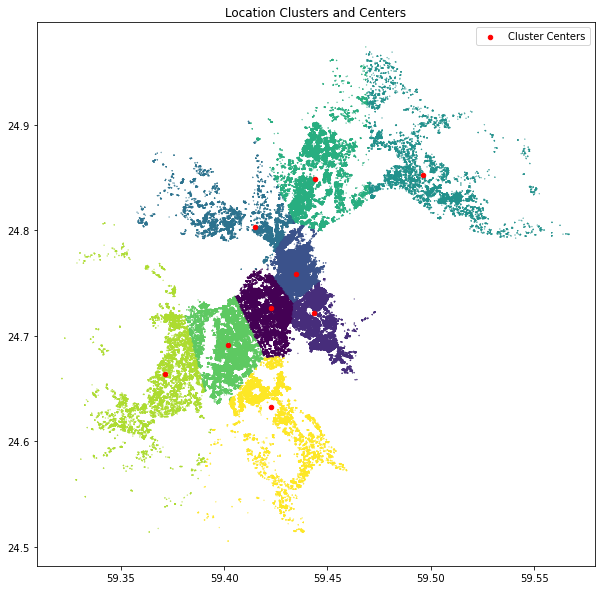

In [572]:
fig = plt.figure(figsize =(10, 10))
plt.scatter(df['start_lat'], df['start_lng'], s=0.1, c=df['start_cluster'])
plt.scatter(clusterCenters[:,0], clusterCenters[:,1], s=20.0, label='Cluster Centers', color='red')
plt.title('Location Clusters and Centers')
plt.legend()

In [626]:
df.to_csv('df_distance_datetime_outlier_cluster.csv')

SOME MORE DATA EXPLORATION PER CLUSTER

We can do some data exploration per cluster using ride information

Text(0.5, 1.0, 'Mean fare per cluster')

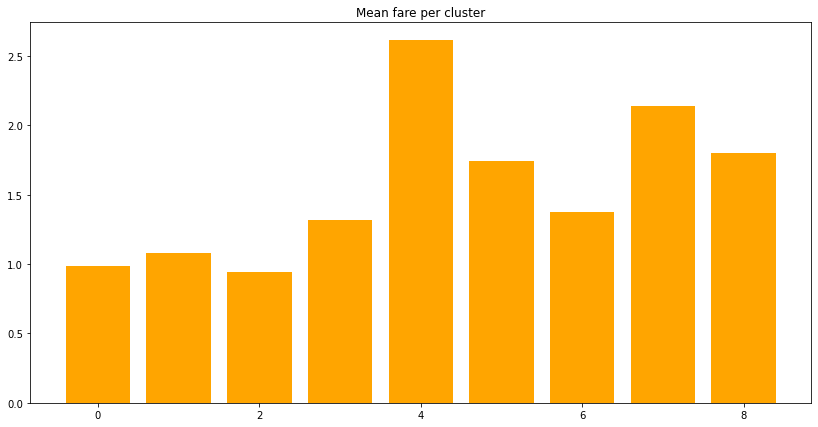

In [459]:
table = df.pivot_table(values='ride_value', index=['start_cluster'], aggfunc='mean')
table.reset_index(inplace=True)

fig = plt.figure(figsize =(14, 7))
plt.bar(table['start_cluster'], table['ride_value'], color='orange')
plt.title('Mean fare per cluster')

Text(0.5, 1.0, 'Number of rides per cluster')

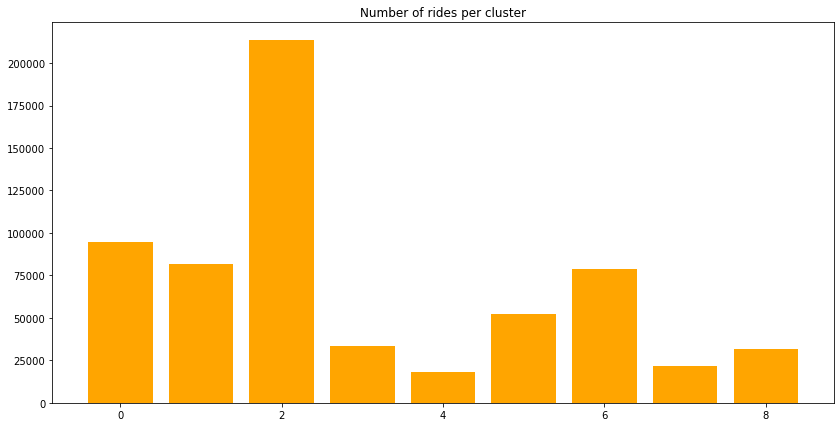

In [460]:
table = df.pivot_table(values='start_time', index=['start_cluster'], aggfunc='count')
table.reset_index(inplace=True)

fig = plt.figure(figsize =(14, 7))
plt.bar(table['start_cluster'], table['start_time'], color='orange')
plt.title('Number of rides per cluster')

Very striking observation: 4th cluster has the fewest rides, mean fare for this cluster is comparatively high. vice versa for 2nd cluster

Finally we can check fare per distance values for each cluster and see if there is a difference

Text(0.5, 1.0, 'Average fare per distance per cluster')

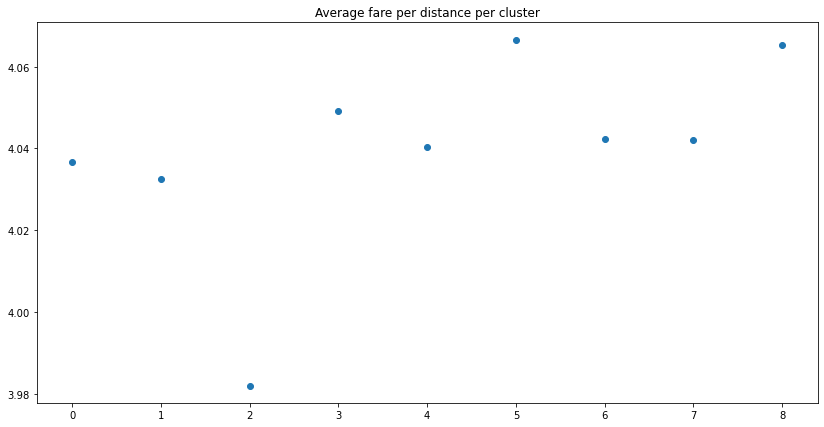

In [461]:
table = df.pivot_table(values='fare_per_distance', index=['start_cluster'], aggfunc='mean')
table.reset_index(inplace=True)

fig = plt.figure(figsize =(14, 7))
plt.scatter(table['start_cluster'], table['fare_per_distance'])
plt.title('Average fare per distance per cluster')

2nd cluster can't catch a break here neither :)

# ESTIMATION

Excess demand estimation is a tricky topic. We need supply data for this particular task. Current data is not sufficient for this

Another thing is to look at is to see the number of rides demanded per cluster per given bin of the day, week and month. Unfortunately this is one month's data, developing a statistical model doesn't make much sense. It is just an aggregation. We can do this using pandas tool and get the aggregate number for each cluster, for each quarter of the day, for each day, for each week of the given data

But here is the kicker, we have seen that there is a very strong trend on total rides per day across weeks. This trend can be estimated and exploited. But first things first. Next table produces the number of rides per cluster, per week of the month, per day of the week and per quarter hour of the day:


In [508]:
df.groupby(['start_cluster', 'start_week', 'start_weekday', 'start_bin_day'])['start_time'].count()

start_cluster  start_week  start_weekday  start_bin_day
0              0           Friday         0                36
                                          1                30
                                          2                27
                                          3                31
                                          4                18
                                                           ..
8              3           Wednesday      43               39
                                          44               19
                                          45               26
                                          46               26
                                          47               26
Name: start_time, Length: 12093, dtype: int64

We can do the same for average fare:

In [509]:
#we can also use pivot table,which I will be using
df.pivot_table(values='ride_value', index=['start_cluster', 'start_week', 'start_weekday', 'start_bin_day'], aggfunc='mean')

ride_value
start_cluster start_week start_weekday start_bin_day            
0             0          Friday        0                1.094812
                                       1                1.058942
                                       2                1.128065
                                       3                0.838903
                                       4                0.720208
...                                                          ...
8             3          Wednesday     43               1.742356
                                       44               2.179572
                                       45               2.112466
                                       46               2.112421
                                       47               1.834475

[12093 rows x 1 columns]

## LIGHTGBM ESTIMATOR

We will be using lightgbm estimator with some categorical values to estimate the fare values. First we are using cluster information, week info, day of the week info and finally half hour bin of the day information

I picked LightGBM for its performance, accuracy and its ease of handling categorical variables which removes the necessity of creating one hot encoding and also it doesn't require standardization.

### PIPELINE AND FEATURE SELECTION

No need for data transformation is needed for the modeling part. Features were already created before. No need for pipelines. Since it is all categorical data that will be used for the first model, no standardization will be done (also tree models are good at non-standardized data, so standardization was not used in the second model neither)

I am not doing any feature selection since the features are basically time and pick up location for a cab driver to check. Basically this model estimates the average fare per cluster per time of the day, day of the week. Week of the month info was used as well but did not improve the results. Drop location info, fare info, distance info are not used neither because a driver will not know these until they pick up a rider. This model will most probably not be able to beat the averages provided in the pivot table provided above. Nonetheless the modelling will be conducted as an exercise to see how good/bad the model is

First pick the feature set selection and mark categorical values as categorical. Then train-test split is done

In [575]:
feature_set = ['start_cluster', 'start_day', 'start_bin_day']
categorical_features = ['start_cluster', 'start_day', 'start_bin_day']
target_value = 'ride_value'

X, y = df[feature_set].copy(), df[target_value].copy()

In [576]:
for c in categorical_features:
    X[c] = X[c].astype('category')

In [577]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_test.shape,  X_train.shape)
print(y_test.shape,  y_train.shape)

(125068, 3) (500268, 3)
(125068,) (500268,)


In [578]:
X

,start_cluster,start_day,start_bin_day
0,6,6,30
1,2,3,22
2,2,6,28
3,6,3,18
4,2,6,0
...,...,...,...
627205,4,2,12
627206,2,5,17
627207,6,2,12
627208,2,3,2



Next the parameters are given. We will conduct a cross validation exercise to find the best parameters for this model.


In [580]:
params = { 'max_depth': [-1 , 3],
           'num_leaves': [20, 31],
           'min_data_in_leaf' : [20], 
           'learning_rate': [0.05, 0.01],
           'subsample': [0.5, 1.],
           'lambda_l1' :[0., 0.1, 1.] ,
           #'lambda_l2' :[0., 0.1, 1.] ,
           'max_bin' :[63, 255],
           'n_estimators': [50, 100,200],
           }

lgm = lgb.LGBMRegressor(categorical_feature=[categorical_features], seed=42)

clf = GridSearchCV(estimator=lgm, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1, cv = 4)

Then fit the data

In [ ]:
clf.fit(X_train, y_train)

record the best parameters and the model

In [591]:
clfBestparams = clf.best_params_
clfBestModel = clf.best_estimator_
clfBestparams

{'lambda_l1': 0.0,
 'learning_rate': 0.05,
 'max_bin': 63,
 'max_depth': -1,
 'min_data_in_leaf': 20,
 'n_estimators': 100,
 'num_leaves': 20,
 'subsample': 0.5}

Predict the fare values, calculate the mean squared error:

In [592]:
ypred = clf.best_estimator_.predict(X_test)

In [593]:
mean_squared_error(y_test, ypred)

0.6480873673329078

Is this a good estimation or bad one?

In [574]:
print(y_test.mean())
print(y_test.std())

1.243193551699623
0.9031253885255512


Some further inspection can be done later to see where the estimation failed most by looking at subcategories of time and cluster

### Trying lattitude longtitude information directly

I am not standardizing data since this is a tree based model

Here we just remove the cluster info and use the lattitude longtitude directly to just use fare prediction. The problem with this method may not be as useful for a driver like the cluster info. the model input may need to be first transformed for a end-user. With cluster information you tell a driver to just drive to a certain location. Not so with the coordinate information since the fare information may not be distributed smoothly


In [627]:
feature_set = ['start_lat','start_lng', 'start_week', 'start_day', 'start_bin_day']
categorical_features = ['start_week', 'start_day', 'start_bin_day']
target_value = 'ride_value'

X, y = df[feature_set].copy(), df[target_value].copy()


In [628]:
for c in categorical_features:
    X[c] = X[c].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_test.shape,  X_train.shape)
print(y_test.shape,  y_train.shape)

(125068, 5) (500268, 5)
(125068,) (500268,)


In [629]:
X_train

,start_lat,start_lng,start_week,start_day,start_bin_day
285774,59.424907,24.744558,3,6,41
80189,59.428430,24.706252,1,0,27
603598,59.387860,24.703787,0,2,10
249440,59.408308,24.688405,2,0,22
408595,59.451656,24.715759,1,2,33
...,...,...,...,...,...
110587,59.428661,24.751088,1,6,1
259947,59.438255,24.751123,0,4,46
366951,59.513502,24.829597,0,6,44
132322,59.422897,24.801635,0,2,27


In [564]:
params = { 'max_depth': [-1 , 3],
           'num_leaves': [20, 31],
           #'min_data_in_leaf' : [20], 
           'learning_rate': [0.05, 0.01],
           #'subsample': [0.5, 1.],
           'lambda_l1' :[0.1, 1.] ,
           #'lambda_l2' :[0., 0.1, 1.] ,
           'max_bin' :[63, 255],
           'n_estimators': [50, 100,200],
           }

lgm_coord = lgb.LGBMRegressor(categorical_feature=[categorical_features], seed=42)

clf_coord = GridSearchCV(estimator=lgm_coord, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1, cv=4)

In [ ]:
clf_coord.fit(X_train, y_train)

In [566]:
clfCoordBestparams = clf_coord.best_params_
clfCoordBestModel = clf_coord.best_estimator_
clfCoordBestparams

{'lambda_l1': 0.1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'max_depth': -1,
 'n_estimators': 200,
 'num_leaves': 31}

Calculate the MSE:

In [567]:
ypred = clf_coord.best_estimator_.predict(X_test)
mean_squared_error(y_test, ypred)

0.6047392250185678

Previous one was 0.648. This is some improvement

### SHAP VALUE EXERCISE

I wanted to do some shap value exercise for the week of the month variable in the second model but my computer did not run the shap package. Sorry. 